<a href="https://colab.research.google.com/github/benreeves/pydata-calgary/blob/master/Bayesian-Series/Applied-MCMC/covid_market_case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PyMC3 Covid Crisis in S&P500 Demo

In this demo, we'll take a look at how the volatility of the stock market evolved during the covid-19 crisis. We'll use a stochastic volatilty model for this. 

We'll hypothesize that there is an unobservable, latent "risk level" in the stock market which moves around randomly over time. When the risk level is high, the stock market gets volatile and stock prices go up and down by a large amount. When the risk level drifts low, stock prices move more mildly.

In [ ]:
# We need to install some tools for the collab runtime
!pip install -U pymc3
!pip install arviz==0.10 # latest arviz broken on collab

Requirement already up-to-date: pymc3 in /usr/local/lib/python3.6/dist-packages (3.10.0)


In [ ]:
import numpy as np
import pandas as pd
import requests
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.style as style
import pymc3 as pm
import arviz as az
import seaborn as sns
from IPython.display import display, Markdown

In [ ]:
%matplotlib inline
style.use('fivethirtyeight')
date_range = pd.IndexSlice['2019':]

In [ ]:
# Download S&P 500 returns from google
# Here we do some funky stuff to manipulate the url so we can download the direct 
# csv link with pandas. This will break at some point in the future.
orig_url='https://drive.google.com/file/d/1YUQSHm8gYIctKlAnWHORjtZuIo_wle--/view?usp=sharing'
file_id = orig_url.split('/')[-2]
# raw download url
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
# Grab data with pandas
df = pd.read_csv(csv_raw, index_col='date', parse_dates=True)
df = df.loc[date_range]

Text(0, 0.5, 'Return Index')

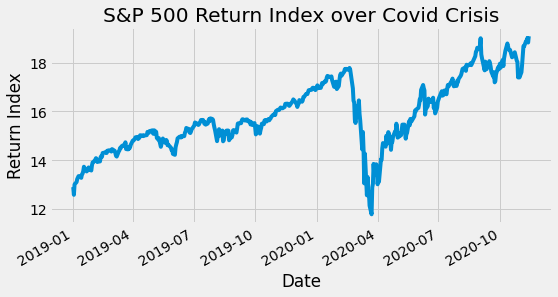

In [ ]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
df.plot(title='S&P 500 Return Index over Covid Crisis', ax=ax, legend=False)
ax.set_xlabel('Date')
ax.set_ylabel('Return Index')

Text(0.5, 1.0, 'Daily returns in the S&P 500 over Covid-19')

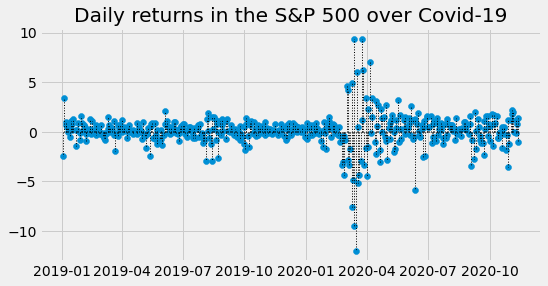

In [ ]:
# Make the same plot but for daily returns
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
returns = df.pct_change().dropna() * 100
returns.rename(columns={'return_index': 'returns'}, inplace=True)
ax.scatter(returns.index, returns)
plt.vlines(returns.index, 0, returns, linestyle="dotted", linewidth=1)
ax.set_title('Daily returns in the S&P 500 over Covid-19')

### How does the average daily return change over time?

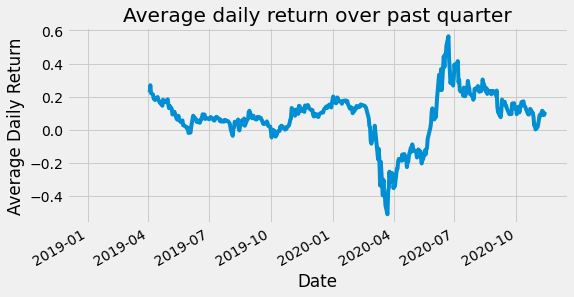

In [ ]:
display(Markdown('### How does the average daily return change over time?'))
fig = plt.figure(figsize=(8,4))
ax2 = fig.add_subplot(111)
ax2.set_xlim(ax.get_xlim())
returns.rolling(63).mean().plot(ax=ax2, title='Average daily return over past quarter', legend=False)
ax2.set_ylabel('Average Daily Return')
ax2.set_xlabel('Date');

### Build the stochastic volatility model

Here, we use the following hierarchical model: daily returns come from a zero mean Student-t distribution. The t distribution's scale parameter (analagous to standard deviation in a normal dist) drifts around in a gaussian random walk. We assume that the degrees of freedom in the t distribution stay constant over time. 


Intuitively, we're saying that the latent risk in the market just follows a random walk process with no rhyme or reason. While you wouldn't want to invest based on this simplification, it works well to analyze the evolution of markets for demonstration purposes.


Expressed in mathspeak, we have

$$ \sigma \sim Exponential(50) $$
$$ \nu \sim Exponential(.1) $$
$$ s_i \sim Normal(s_{i-1}, \sigma^{-2}) $$
$$ r_i \sim t(\nu, 0, exp(-2 s_i)) $$

In [ ]:
# Lets build the model
with pm.Model() as sp500_model:
    # The model remembers the datetime index with the name 'date' by using
    # the export_index_as_coords=True
    change_returns = pm.Data(
        "returns", returns['returns'], dims="date", export_index_as_coords=True
    )

    # degrees of freedom in the student t distribution
    # here we just pick 1/10 out of a hat to give an average dof of 10 which 
    # seems like a good guess. We use an exponential dist because it's > 0 with 
    # support decaying out at large values of nu
    nu = pm.Exponential("nu", 1 / 10.0, testval=5.0)
    
    # Set the innovation size for our gaussian random walk
    step_size = pm.Exponential("step_size", 2.0, testval=0.1)

    # Let volatility drift as a gaussian random walk with vol step 
    # sizes defined by step size above
    s = pm.GaussianRandomWalk("s", sigma=step_size, dims="date")

    # transform our vol parameter in the shape the StudentT expects 
    volatility_process = pm.Deterministic(
        "volatility_process", pm.math.exp(-2 * s) ** 0.5, dims="date"
    )

    # we will draw returns from a StudentT distribution with nu degrees of
    # freedom and a volatility that changes according to volatility_process
    r = pm.StudentT(
        "r", nu=nu, sigma=volatility_process, observed=change_returns, dims="date"
    )

We can create a handy visualization of the model!

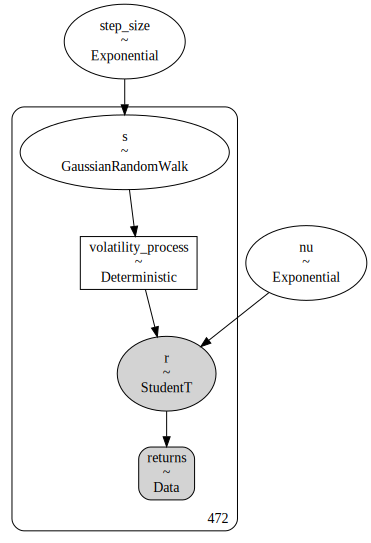

In [ ]:
pm.model_to_graphviz(sp500_model)

In [ ]:
# alrighty! let's sample from our model
with sp500_model:
    trace = pm.sample(2000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [s, step_size, nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 123 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


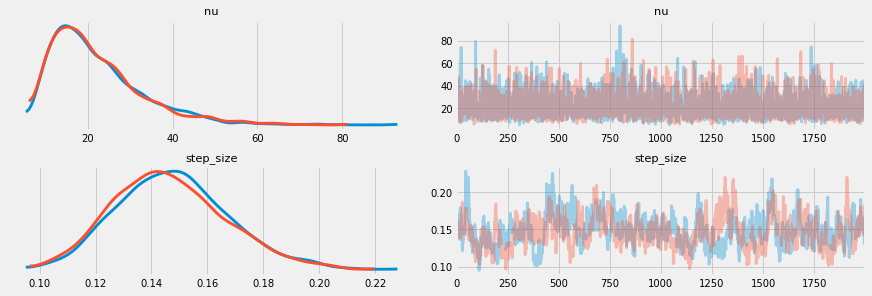

In [ ]:
az.plot_trace(trace, var_names=["nu", "step_size"]);

What we see above is the distribution of parameters sampled from the posterior. We can see that our degrees of freedom is probably around 10-30, but could be quite higher at 40-50. We also see that the average change in our scale parameter from day to day is about 0.15.

The two colours represent the sampling distribution from two different chains. Remember that MCMC uses dependent sampling - we draw samples based on the last sample we drew. In order to diagnose issues around convergence and increase our effective number of samples, we typically draw samples in parallel from multiple chains. Each chain runs on a core of your machine. So here, in google collab, we get 2 chains. On a different machine, we may have more chains when we have more cores available.

We want to see that each chain has converged to (about) the same posterior. That is, our blue and red lines should overlap nicely showing that they were getting similar results. If they are vastly different, we probably have issues with our sampling and are not efficiently exploring our probability space. 

We want to see a nice "fuzzy caterpillar" on the right hand charts. That shows that the sampler is efficiently exploring the posterior spaces. If you see the sampler getting stuck and flatlining out, that could be due to a misspecified model or areas of high curvature. You either have bad assumptions, or you can try reparamterizing your model. See https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/

In [ ]:
with sp500_model:
    posterior_predictive = pm.sample_posterior_predictive(trace)

In [ ]:
posterior_predictive.keys()

dict_keys(['r'])

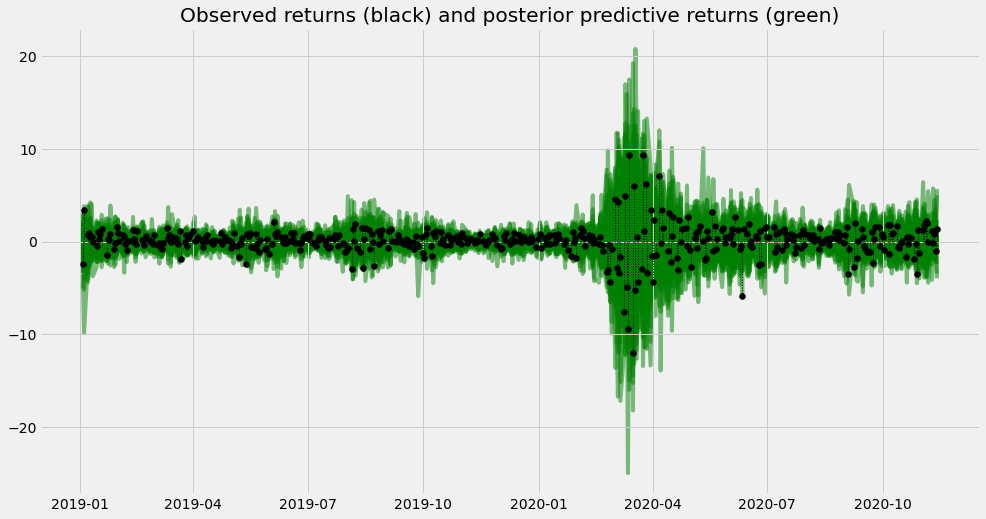

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(returns.index, returns, color='k')
plt.vlines(returns.index, 0, returns, linestyle="dotted", linewidth=1, color='k')
ax.set_title("Observed returns (black) and posterior predictive returns (green)")
plt.plot(returns.index, posterior_predictive["r"][::100].T, "g", alpha=0.5, zorder=-10);

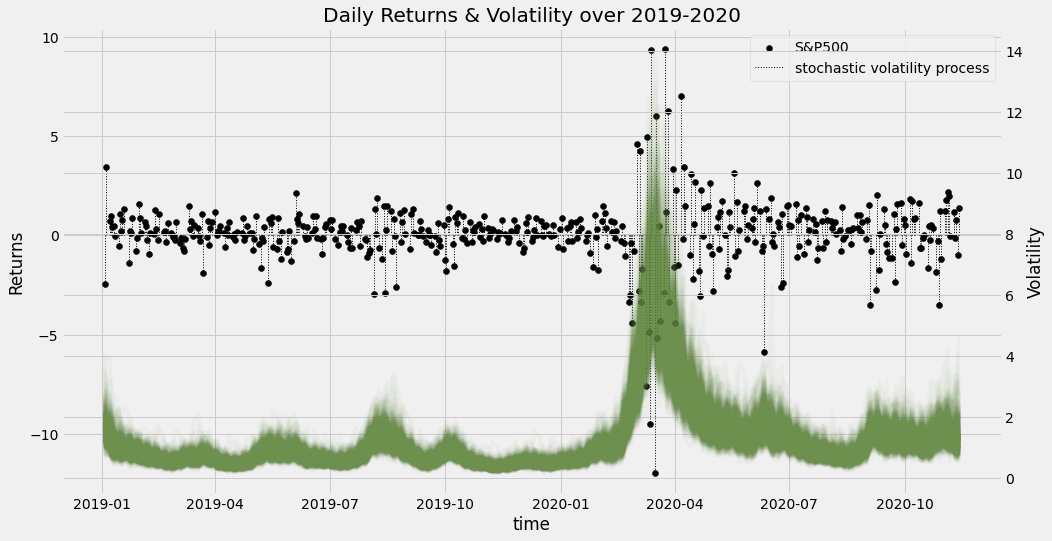

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(returns.index, returns, color='k')
plt.vlines(returns.index, 0, returns, linestyle="dotted", linewidth=1, color='k')
ax.set_title('Observed Daily Returns')
ax.set_ylabel('Returns')

ax2 = ax.twinx()
ax2.plot(returns.index, 1 / np.exp(trace["s", ::5].T), "C3", alpha=0.03)
ax.set(title="Daily Returns & Volatility over 2019-2020", xlabel="time")
ax2.set_ylabel('Volatility')

ax.legend(["S&P500", "stochastic volatility process"], loc="upper right");


Cool! Let's see if we can enhance this model by adding a drifting mean to our volatility process. 

Our hypothesis is that the average daily return also follows a gaussian random walk. Let's check to see how well this holds up...

In [ ]:
# same things as before, but now let's add in a mean process similar to our volatility process
with pm.Model() as sp500_model2:
    # The model remembers the datetime index with the name 'date'
    change_returns = pm.Data(
        "returns", returns['returns'], dims="date", export_index_as_coords=True
    )
    # degrees of freedom in the student t distribution
    nu = pm.Exponential("nu", 1 / 10.0, testval=5.0)
    step_size = pm.Exponential("step_size", 2.0, testval=0.1)

    #### Mean defn
    step_size_mean = pm.Exponential("step_size_mean", 1/20, testval=0.01)
    mean_ = pm.GaussianRandomWalk("mean_", sigma=step_size_mean, dims="date")

    s = pm.GaussianRandomWalk("s", sigma=step_size, dims="date")
    volatility_process = pm.Deterministic(
        "volatility_process", pm.math.exp(-2 * s) ** 0.5, dims="date"
    )

    r = pm.StudentT(
        "r", nu=nu, mu=mean_, sigma=volatility_process, observed=change_returns, dims="date"
    )


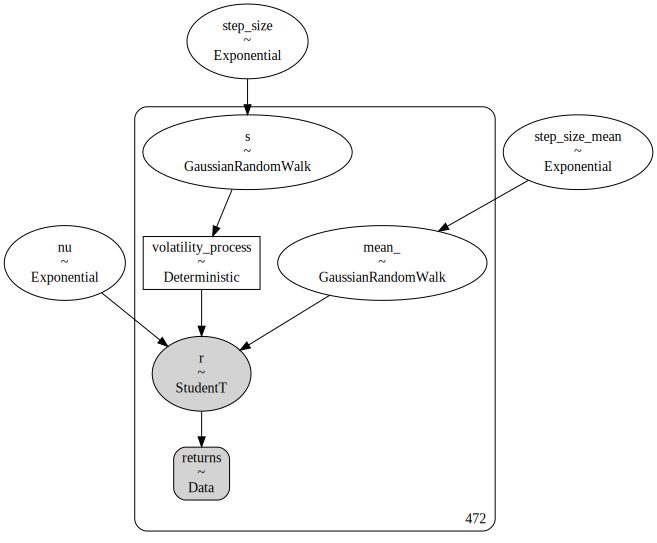

In [ ]:
pm.model_to_graphviz(sp500_model2)

In [ ]:
with sp500_model2:
    trace2 = pm.sample(2000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [s, mean_, step_size_mean, step_size, nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 956 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.888486286137851, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


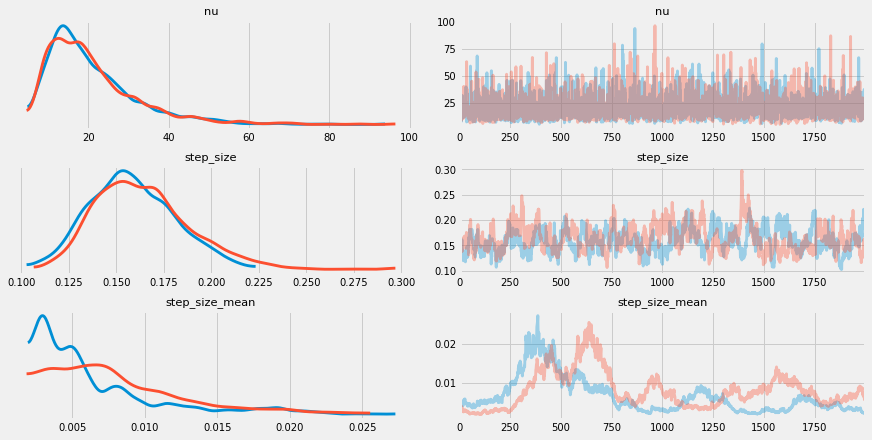

In [ ]:
az.plot_trace(trace2, var_names=["nu", "step_size", "step_size_mean"]);

Here we some an example of our sampler failing to converge. On the traceplots to the right, notice how the sampler gets stuck in some local region of posterior space and can't break out. We also see that each chain (our red and blue lines) don't look like nice overlaps of each other, but have distinctly different shapes. This is telling us that our samplers came to different conclusions about what parameters were possible. This is indicative of a misspecified model. 

Here, we can postulate that the model wasn't able to sample effectively because we had a complex model with a lot of noise. I would imagine that the changes in volatility over time overpower our mean process, and since each piece is quite complex, we struggle to explore the parameter space.

Well, let's note that this is messed up and continue our charge!

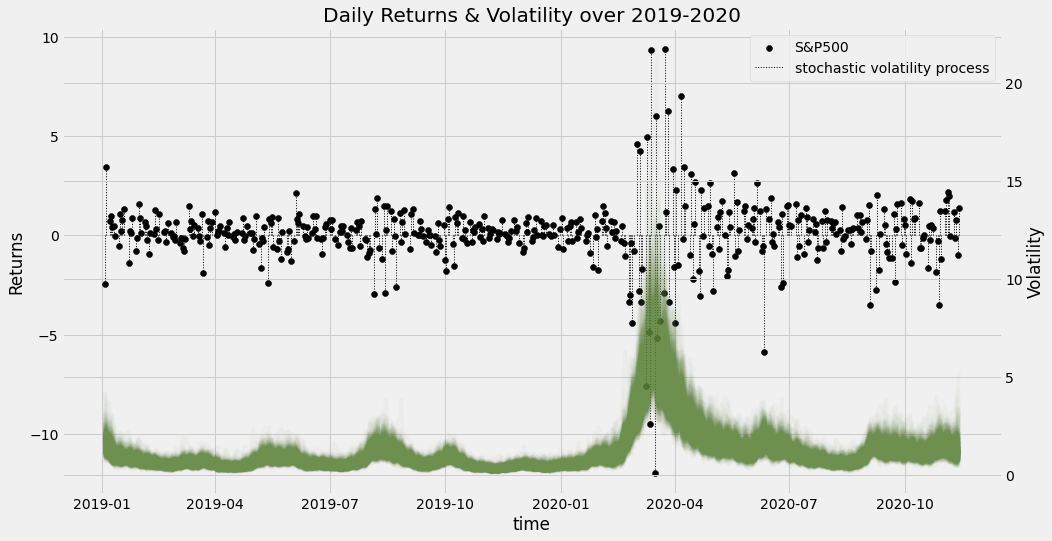

In [ ]:
# repeat our volatility chart
fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(returns.index, returns, color='k')
plt.vlines(returns.index, 0, returns, linestyle="dotted", linewidth=1, color='k')
ax.set_title('Observed Daily Returns')
ax.set_ylabel('Returns')

ax2 = ax.twinx()
ax2.plot(returns.index, 1 / np.exp(trace2["s", ::5].T), "C3", alpha=0.03)
ax.set(title="Daily Returns & Volatility over 2019-2020", xlabel="time")
ax2.set_ylabel('Volatility')

ax.legend(["S&P500", "stochastic volatility process"], loc="upper right");

Let's also plot the evolution of the mean daily return over time

(-0.5, 0.5)

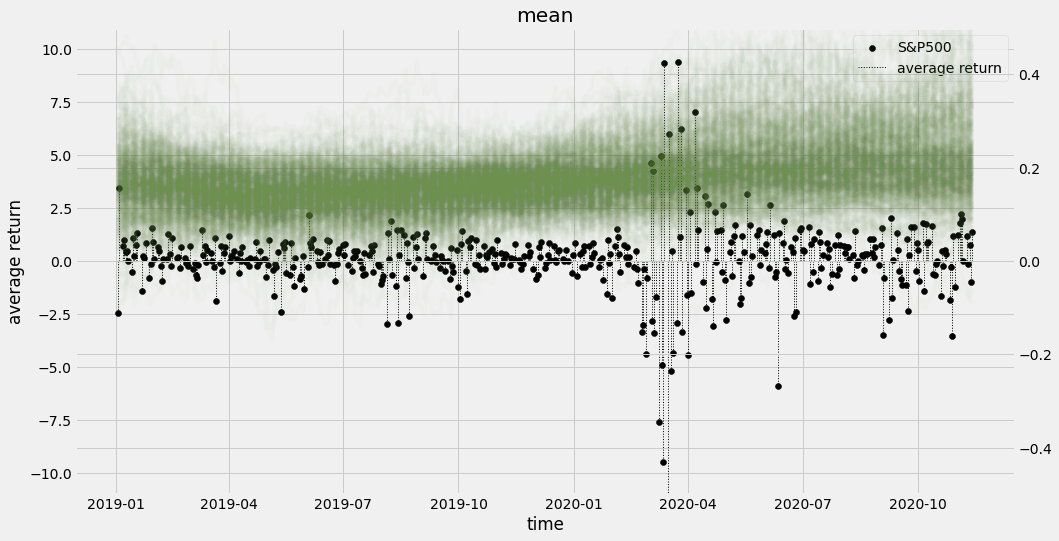

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(returns.index, returns, color='k')
plt.vlines(returns.index, 0, returns, linestyle="dotted", linewidth=1, color='k')
ax2 = ax.twinx()
ax2.plot(returns.index, trace2["mean_", ::5].T, "C3", alpha=0.02)
ax.set(title="mean", xlabel="time", ylabel="average return")
ax.legend(["S&P500", "average return"], loc="upper right");
ax.set_ylim(-11, 11)
ax2.set_ylim(-0.5, 0.5)

We can see that there is clearly a broadening pattern as we hit the coronavirus crisis - with volatility increasing, it becomes difficult to know what the average daily return over the preiod really was. This is probably more instructive to what is wrong with our model than telling us something about the state of financial markets

### Simulate the future!

Alright! Now, let's have some fun and simulate what might happen in the future. I know we mentioned that our model is misspecified, but that's never stopped someone working on a deadline before.

Here, we're going to use the results of our posterior distribution to simulate a few possible paths. For simplicity, we're going to leverage the samplers in pymc3 since they nicely let us build and sample from hierarhical models.

We're going to take the parameters for the current mean and volatility at the last date in our model, make some simplifying assumptions, and then generate some possible paths the future might take.

In [ ]:
# sample 63 days (1 quarter) of data
n = 63
with pm.Model() as sp500_model_posterios:
    # the step size isn's super important, so let's just take the average step
    # over the posterior space
    mean_ = pm.GaussianRandomWalk("mean_walk", sigma=trace2['step_size_mean'].mean(), shape=n)
    
    # we need our initial mean at the starting point. It'll be drawn from a normal
    # distribution with an average of our average at the end of the period and 
    # our sample standard deviation
    mean_init = pm.Normal("init_mean", mu=trace2['mean_'][:, -1].mean(), sd=trace2['mean_'].std())
    
    # the mean at time t is the initial mean plus the random walk drift
    mean = pm.Deterministic("mean", mean_init + mean_)
  
    # set up our volatility process in the same way
    s_init = pm.Normal("s_init", mu=trace2['s'][:, -1].mean(), sd=trace2['s'][:, -1].std())
    s_walk = pm.GaussianRandomWalk("s_walk", sigma=trace2['step_size'].mean(), shape=n)
    s = pm.Deterministic("s", s_init + s_walk)

    volatility_process = pm.Deterministic(
        "volatility_process", pm.math.exp(-2 * s) ** 0.5
    )
    # draw our returns!
    r = pm.StudentT(
        "r", nu=trace2['nu'].mean(), sigma=volatility_process, mu=mean, shape=n
    )
    # draw 30 samples from the prior (note that our old posterior became our 
    # prior for our simulation)
    pp_trace = pm.sample_prior_predictive(30)

/usr/local/lib/python3.6/dist-packages/pymc3/backends/base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


Since the covid crisis was so volatile, it biases our estimate of the long term volatility upwards. As a result, we get some numbers which are a bit outside of expectations. Since this is just for demonstration purposes, we'll just remove out anything which we imagine is outside the realm of the realistic

Text(0.5, 1.0, 'Simulated observed volatility')

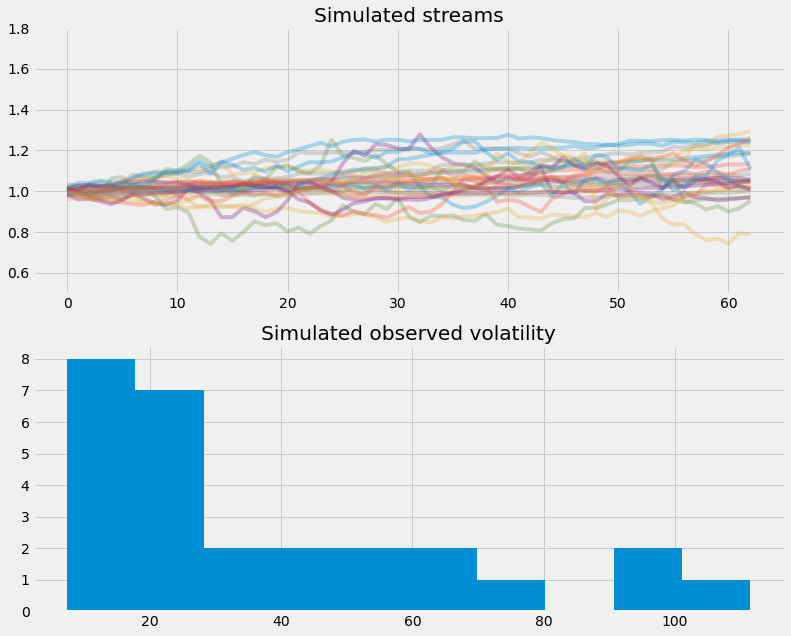

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
growth = ((pd.DataFrame(pp_trace['r'].T) / 100) + 1)
# remove unrealistic extremes
colmask = growth.std() * 100 * np.sqrt(252) < 70
growth = growth[[x for x,y in zip(growth.columns, colmask) if y]]
# create novel return streams
growth.cumprod().plot(alpha=0.3, legend=False, ax=ax1)
ax1.set_ylim((0.5, 1.8))
ax1.set_title('Simulated streams')
ax2.hist(growth.pct_change().std() * 100 * np.sqrt(252))
ax2.set_title('Simulated observed volatility')

Let's plot our simulated results!

Text(0, 0.5, 'S&P 500 return index')

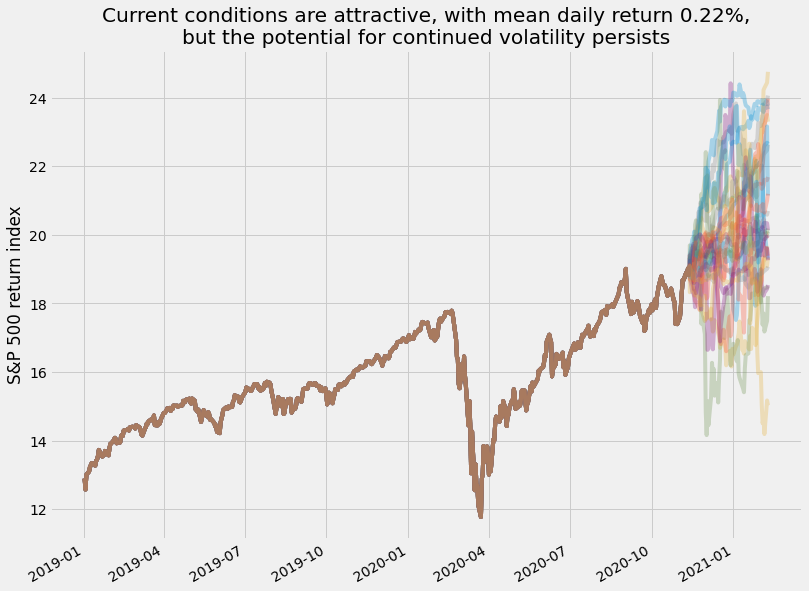

In [ ]:
f, ax = plt.subplots(1,1, figsize=(12, 10))
possibilities = growth.cumprod().apply(lambda x: x * df.iloc[-1].values[0])
possibilities = possibilities.set_index(pd.date_range(start=df.index[-1], periods=63, freq='B'))
possibilities.apply(lambda x: pd.concat([df.squeeze(), x]), raw=False).plot(alpha=0.3, legend=False,ax=ax)
avg_daily = trace2['mean_'][:, -1].mean()
ax.set_title('Current conditions are attractive, with mean daily return {:.2f}%,\nbut the potential for continued volatility persists'.format(avg_daily))
ax.set_ylabel('S&P 500 return index')

Even though it looks like the current state is attractive for investment, we may want to stay cautios as our volatility process hasn't yet decayed back down to stability